In [1]:
# execute to import notebook styling for tables and width etc.
from IPython.core.display import HTML
import urllib.request
response = urllib.request.urlopen('https://raw.githubusercontent.com/DataScienceUWL/DS775v2/master/ds755.css')
HTML(response.read().decode("utf-8"));

In [2]:
# imports
import numpy as np
from scipy import interpolate
from scipy.optimize import minimize_scalar, minimize
import matplotlib.pyplot as plt
import json
import time
import seaborn as sns
sns.set_style("darkgrid")

# *Self Assessment:  Minimize to Maximize*

In [3]:
from scipy.optimize import minimize
P = lambda x: -0.008 * x**2 + 3.1 * x - 80  # lambda is for writing one line functions
neg_P = lambda x: -P(x)
result = minimize(neg_P, x0=150, bounds=[(0, 250)])
print(f"The maximum profit is ${-result.fun[0]:,.2f} and occurs when {result.x[0]:3.2f} apartments are rented.")

The maximum profit is $220.31 and occurs when 193.75 apartments are rented.


193.75 is the relaxed solution, but we can't rent 193.75 apartments.  Let's check 193 and 194 to see which yields a larger profit.

In [4]:
P(193),P(194)

(220.30800000000005, 220.31199999999995)

Bottom line:  rent 194 apartments for profit $220,312.

# *Self Assessment:  Finding Multiple Extrema*

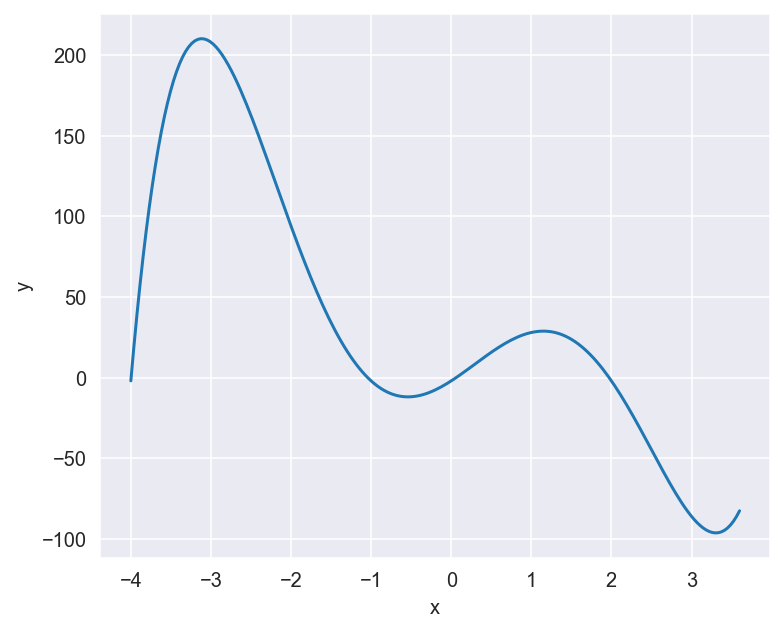

In [5]:
# first graph the function
import numpy as np
import matplotlib.pyplot as plt
x = np.linspace(-4,3.6,201)
f = lambda x:x**5-x**4-18*x**3+16*x**2+32*x-2
fig = plt.figure(figsize=(6,5));
plt.plot(x,f(x));
plt.xlabel('x');
plt.ylabel('y');

There appear to be local maxima around $x=-3$ and $x=1$ while there appear to be local minima around $x=-0.5$ and $x = 3.5$.

In [6]:
from scipy.optimize import minimize

# find minima first
x0_min = [-.5,3.5]
for x0 in x0_min:
    result = minimize( f, x0, bounds = [(-4,3.6)])
    print(f"There is a local minimum value of {result.fun[0]:.2f} at x = {result.x[0]:.2f}")
    
# now maxima
neg_f = lambda x:-f(x)
x0_max = [-3,1]
for x0 in x0_max:
    result = minimize( neg_f, x0, bounds = [(-4,3.6)])
    print(f"There is a local maximum value of {-result.fun[0]:3.2f} at x = {result.x[0]:1.2f}")

There is a local minimum value of -11.91 at x = -0.54
There is a local minimum value of -96.27 at x = 3.30
There is a local maximum value of 210.19 at x = -3.11
There is a local maximum value of 28.85 at x = 1.15


**Note - there is a strange quirk here in the scipy.optimize.minimize.**  When we optimize without bounds `result.fun` is a number, but when we optimize with bounds `result.fun` is a list with one number so we have to refer to `result.fun[0]` to get the number.

# *Self-Assessment: Rastrigin with dim = 3, dim = 4*

How many iterations does it take to reliably find the global minimum with dim = 3?  With dim = 4?  Use the multi-start strategy.

In [7]:
def rastrigin(x):
    # pass a single vector of length n (=dim) to evaluate Rastrigin
    return sum(x**2 + 10 - 10 * np.cos(2 * np.pi * x))

The more local searches we perform, the better the probability of locating the global minimum at the origin.  Experiment with the number of local searches to see how the reliability increases.  It turns out that with dim = 3 it takes about 2000 local searches to have a 90% chance at finding the global minimum.  For dim = 4 it takes about 20000 local searches.

It's possible to arrive at these numbers mathematically, but we just want you to get an idea that the number of local searches required increases dramatically as the dimension increases.

In [8]:
from scipy.optimize import minimize
import numpy as np

def multistart_rastrigin(dim,num_local_searches):
    minima = np.zeros(num_local_searches)
    for i in range(num_local_searches):
        x_initial = np.random.uniform(-5.12, 5.12, dim)
        result = minimize(rastrigin, x_initial)
        minima[i] = result.fun
    return minima

dim = 3
num_local_searches = 2000
min_values = multistart_rastrigin(dim,num_local_searches)
successes = sum( min_values < .01)
print(f"The global minimum was found {successes:d} times.")

The global minimum was found 2 times.


In [9]:
# this could take a few minutes!
# if you don't want to run it, I did and found the global min 6 times
dim = 4
num_local_searches = 20000
min_values = multistart_rastrigin(dim,num_local_searches)
successes = sum( min_values < .01)
print(f"The global minimum was found {successes:d} times.")

The global minimum was found 2 times.


# *Self-Assessment:  Rastrigin with dim = 10*

Do 1000 local search with Rastrigin with dim = 10.  What is the smallest value you find?  How long do you think it would take to find the minimum from randomly chosen initial points like this?  

In [10]:
# this may take a minute
dim = 10
num_local_searches = 1000
min_values = multistart_rastrigin(dim,num_local_searches)
print(f"The smallest minimum value found is {np.min(min_values):3.2f}")

The smallest minimum value found is 17.91


With 1000 local searches the minimum value seems to be anywhere from 12 to 26.  Increasing the number of searches helps, but it's not clear how many iterations to use, but it's likely a lot!

# *Self-Assessment:  How many searches?*

We'll start by writing a function that repeats the local search process until the global minimum is found and returns the total number of local searches.

In [11]:
def repeat_until_found(dim):
    best_value = 1.e10
    iterations = 0
    while best_value > 0.01:
        iterations += 1
        x_initial = np.random.uniform(-5.12, 5.12, dim)
        result = minimize(rastrigin, x_initial)
        if result.fun < best_value:
            best_value = result.fun
    return(iterations)

repeat_until_found(1)

4

Now we do this 100 times for each of dim = 1,2,3 and gather the results.  This code may take several minutes to run.

In [12]:
num_trials = 100
dims = np.array([1,2,3])
iterations = np.zeros((num_trials,len(dims)))
for i in range(num_trials):
    for j in range(len(dims)):
        iterations[i,j] = repeat_until_found(dims[j])

In [13]:
average_iterations = np.mean(iterations, axis=0)
for j in range(len(dims)):
    print(
        'In dimension {:d} it takes {:3.1f} local searches, on average, to find the global min.'
        .format(dims[j], average_iterations[j]))

In dimension 1 it takes 8.7 local searches, on average, to find the global min.
In dimension 2 it takes 99.2 local searches, on average, to find the global min.
In dimension 3 it takes 981.0 local searches, on average, to find the global min.


The number of searches increases roughly by an order of magnitude (power of 10) for each added dimension.

# *Self Assessment: How many searches when dim = 10?*

Approximately now many local searches are required to find the global minimum one time when dim = 10?  Is it surprising that you (very likely) didn't find it with 1000 local searches?  Explain

The number of searches would be approximately $(10.28)^{10}$ or

In [14]:
print(f"{10.28**10:,.2f}")

13,180,477,576.06


That's about 13 billion local searches.  Even if we did 10,000 local searches per second, it would still take about two weeks to do enough to find the global minimum once:

In [15]:
# number of weeks to do local searches at 10,000 per second
(10.28**10)/10000/3600/24/7

2.179311768528369

Fortunately there are better approaches that can often deliver results in much less time!

## *Self Assessment: Value Balancing Local Search*

In [6]:
# Solution - call this function for local search

def group_balance_search(values, num_groups, max_no_improve, debug=False):
  
    #get the total number of items
    num_items = values.shape[0]
    
    #assign them to the number of groups
    current_groups = np.random.randint(low=0,
                                          high=num_groups, size=num_items)
    #get the current_fitness
    current_fitness =  group_fitness(values, current_groups)
        
    num_moves_no_improve = 0
    while (num_moves_no_improve < max_no_improve):
        num_moves_no_improve += 1
        new_groups = change_group(current_groups, debug)
        new_fitness = group_fitness(values, new_groups)
        if debug:
            print(f'Old fitness: {current_fitness}, New fitness {new_fitness}')
        if new_fitness < current_fitness:
            current_fitness = new_fitness
            current_groups = new_groups
            num_moves_no_improve = 0
    return current_fitness, current_groups

In [10]:
# set up data for 4 item/ two group problem
values = np.array([5,10,23,8])

# search
fitness, groups = group_balance_search(values, 2, 10, debug=False)
print(f'The final fitness is {fitness}')

print('Our dataframe, after grouping and summing')
display(df.groupby(groups).sum('values'))

The final fitness is 0.0
Our dataframe, after grouping and summing


,values,groups
0,23,0
1,23,2


For the 1000 item problem we generally achieve a local minimum max difference of groups to be anywhere from 2 to 120.

In [16]:
# set up data for 1000 item / 4 group problem
np.random.seed(5)
values = np.random.randint(2,20,size=1000)
np.random.seed()

fitness, groups = group_balance_search(values, 4, 200, debug=False)

print(f'The max difference between groups is {fitness}')

#Numpy arrays can easily be tossed into dataframes
df = pd.DataFrame({'values': values, 'groups': groups})

#then we can group the dataframe by our groups column, and sum the values
print('Our dataframe, after grouping and summing')
display(df.groupby(groups).sum('values'))

The max difference between groups is 118.0
Our dataframe, after grouping and summing


,values,groups
0,2825,0
1,2709,260
2,2591,484
3,2473,720
